In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.visualization import (ZScaleInterval, ImageNormalize)
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

In [2]:
cutout_dir = os.path.expandvars("$SCRATCH") + "/"
image_dir = "/home/anahoban/projects/rrg-kyi/astro/cfis/W3/"

In [3]:
#get tile ids
tile_list = open(image_dir + "tiles.list", "r")

# Only use tiles with all five channels
tile_list = open(image_dir + "tiles.list", "r")
tile_ids = []

for tile in tile_list:
    tile = tile[:-1] # Remove new line character
    channels = tile.split(" ")
    if len(channels) == 5: # Order is u,g,r,i,z
        tile_ids.append(channels[0][5:12]) # XXX.XXX id
tile_list.close()

In [4]:
hf = h5py.File(cutout_dir + "cutouts_filtered.h5", "r")

In [5]:
n_cutouts = 0
for i in range(5):
    print(i)
    n_cutouts += len(hf.get(tile_ids[i] + "/IMAGES"))
print(n_cutouts)


0
1
2
3
4
57399


In [6]:
n_valid = len(hf.get(tile_ids[12] + "/IMAGES"))

In [7]:
# tiles for val and training
train_indices = range(2)
val_indices = [12]

In [8]:
BATCH_SIZE = 256 #128
CUTOUT_SIZE = 128
N_EPOCHS = 8 #12
weights_cfis = np.zeros((BATCH_SIZE, CUTOUT_SIZE, CUTOUT_SIZE, 1))
weights_ps1 = np.zeros((BATCH_SIZE, CUTOUT_SIZE, CUTOUT_SIZE, 3))
weights_all = np.zeros((BATCH_SIZE, CUTOUT_SIZE, CUTOUT_SIZE, 5))

In [45]:
def get_test_cutouts(index, n_cutouts, cutout_size, bands="cfis", start=0):
    n = 0
    if bands == "all":
        band_indices = [0, 1, 2, 3, 4]
        l = len(band_indices)
        sources = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        weights = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        
        
    elif bands == "cfis":
        band_indices = [2]
        l = len(band_indices)
        sources = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        weights = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        
    else: # PS1
        band_indices = [1, 3, 4]
        l = len(band_indices)
        sources = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        weights = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        
    img_group = hf.get(tile_ids[index] + "/IMAGES")
    wt_group = hf.get(tile_ids[index] + "/WEIGHTS")
    for i in range(start, len(img_group)):
        sources[n,:,:,:] = np.array(img_group.get(f"c{i}"))[:,:,band_indices]
        weights[n,:,:,:] = np.array(wt_group.get(f"c{i}"))[:,:,band_indices]
        n += 1
        if n == n_cutouts:
            return np.concatenate((sources, weights),axis=-1)

In [46]:
test_index = 13
#sources_test_cfis = get_test_cutouts(test_index, 50, cutout_size, "cfis")
#sources_test_ps1 = get_test_cutouts(test_index, 50, cutout_size, "ps1")
sources_test_all = get_test_cutouts(test_index, 50, CUTOUT_SIZE)
sources_test_all.shape

(50, 128, 128, 2)

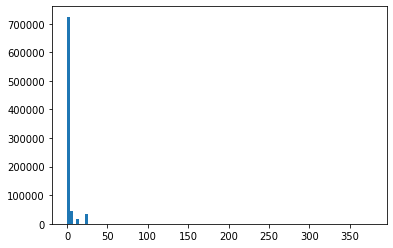

In [17]:
plt.hist(sources_test_all[...,0].flatten(), bins = 100);

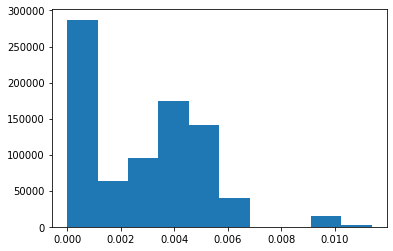

In [15]:
plt.hist(sources_test_all[...,3].flatten(), bins = 10);

In [39]:
def get_cutouts(tile_indices, batch_size, cutout_size, bands="all"):
    ''' Input: hf file, tile indices, batch size, dimensions, band and bands
        Output: the img and weight cutouts for the test set as (batch_size, pix, pix, channels) '''
    b = 0 # counter for batch
    if bands == "all":
        band_indices = [0, 1, 2, 3, 4]
    elif bands == "cfis":
        band_indices = [2]
        l = len(band_indices)
    elif bands == "ps1":
        band_indices = [1, 3, 4]
    else:
        print('WARNING: unrecognized band')
        band_indices = [0]   
 
    l = len(band_indices)
    sources = np.zeros((batch_size, cutout_size, cutout_size, l))
    weights = np.zeros((batch_size, cutout_size, cutout_size, l))
    while True:
        for i in tile_indices:
            img_group = hf.get(tile_ids[i] + "/IMAGES")
            wt_group = hf.get(tile_ids[i] + "/WEIGHTS")
            n_cutouts = len(img_group)
            for n in range(n_cutouts):
                sources[b,:,:,:] = np.array(img_group.get(f"c{n}"))[:,:,band_indices]
                weights[b,:,:,:] = np.array(wt_group.get(f"c{n}"))[:,:,band_indices]
                b += 1
                if b == batch_size:
                    b = 0
                    yield (np.concatenate((sources, weights), axis = 3), sources)

In [40]:
def train_autoencoder(model, train_indices, val_indices, n_epochs, batch_size, cutout_size, bands="all"):
    n_cutouts_train = 0
    for i in train_indices:
        img_group = hf.get(tile_ids[i] + "/IMAGES")        
        n_cutouts_train += len(img_group)
    
    n_cutouts_val = 0    
    for i in val_indices:
        img_group = hf.get(tile_ids[i] + "/IMAGES")        
        n_cutouts_val += len(img_group)
    
    train_steps = n_cutouts_train // batch_size
    val_steps = n_cutouts_val // batch_size
    
    history = model.fit(get_cutouts(train_indices, batch_size, cutout_size, bands), 
                        epochs=n_epochs, steps_per_epoch=train_steps, 
                        validation_data=get_cutouts(val_indices, batch_size, cutout_size, bands), 
                        validation_steps=val_steps)
    return model, history

In [31]:
def create_autoencoder2(shape):
    input_img = keras.Input(shape=shape)
    x = keras.layers.Conv2D(16, kernel_size=3, activation='relu', padding='same')(input_img)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)

    y = keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(input_img)
    y = keras.layers.BatchNormalization()(y)
    encoded = keras.layers.Add()([x,y])
    
    x = keras.layers.Conv2DTranspose(32, kernel_size=4, activation='relu', padding='same')(encoded)
    x = keras.layers.Conv2DTranspose(16, kernel_size=4, activation='relu', padding='same')(x)
    decoded = keras.layers.Conv2D(shape[2], kernel_size=3, activation='linear', padding='same')(x)
    
    return keras.Model(input_img, decoded)

In [49]:
# tiles for val and training
train_indices = [13]#range(1) #range(5)
val_indices = [12]
BATCH_SIZE= 256

In [70]:
def masked_MSE_with_uncertainty(y_true, y_pred):
    y_pred_image = tf.gather(y_pred,indices=[0],axis=-1)
    y_true_image = tf.reshape(y_true,shape=tf.shape(y_pred_image))
    weight = tf.gather(y_pred, indices=[1], axis=-1)
    
    #mask = K.abs(K.sign(y_true_image))
    loss = K.square(tf.math.multiply((y_true_image - y_pred_image), 1) ) 
    print(K.sum(loss))
    return loss
    #mask*(K.square(tf.math.divide_no_nan((y_true_image - y_pred_image), weight)))
    #return K.square(y_true_image - y_pred_image)

In [48]:
tf.gather(sources_test_all[...,1], indices=[1], axis=-1)

<tf.Tensor: shape=(50, 128, 1), dtype=float64, numpy=
array([[[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.00220454],
        [0.00220454],
        [0.00220454],
        ...,
        [0.00219381],
        [0.00219381],
        [0.00219489]],

       [[0.00578248],
        [0.00579142],
        [0.00579142],
        ...,
        [0.00577432],
        [0.00577432],
        [0.00577432]],

       ...,

       [[0.00282639],
        [0.00282012],
        [0.00282012],
        ...,
        [0.00282162],
        [0.00282162],
        [0.00281539]],

       [[0.00364814],
        [0.00362674],
        [0.00362674],
        ...,
        [0.0036022 ],
        [0.0036022 ],
        [0.0036022 ]],

       [[0.00609972],
        [0.00609972],
        [0.00609972],
        ...,
        [0.00611568],
        [0.00611568],
        [0.00611901]]])>

In [61]:
c = tf.constant([[1.0, 2.0], [-3.0, 4.0]])

In [66]:
K.sum(K.abs(K.sign(c)))

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

In [71]:
autoencoder_cfis = create_autoencoder2((CUTOUT_SIZE, CUTOUT_SIZE, 1))
autoencoder_cfis.compile(optimizer="adam", loss=masked_MSE_with_uncertainty)

In [45]:
autoencoder_cfis.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 128, 128, 16) 160         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 128, 128, 16) 64          conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 32) 4640        batch_normalization_12[0][0]     
_______________________________________________________________________________________

In [72]:
(autoencoder_cfis, history_cfis) = train_autoencoder(autoencoder_cfis, train_indices,  val_indices, batch_size=BATCH_SIZE,
                                                     cutout_size=CUTOUT_SIZE, n_epochs= N_EPOCHS, bands="cfis")
   

Epoch 1/8
Tensor("masked_MSE_with_uncertainty/Sum:0", shape=(), dtype=float32)
Tensor("masked_MSE_with_uncertainty/Sum:0", shape=(), dtype=float32)
27/51 [==============>...............] - ETA: 33s - loss: 1.3254

KeyboardInterrupt: 

In [22]:
def plot_loss_curves(history, figname):
    plt.plot(history.history["loss"], color="g", label="Training")
    plt.plot(history.history["val_loss"], color="b", label="Validation")
    plt.title("Loss Curves for Training/Validation Sets")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("../Loss Curves/" + figname)

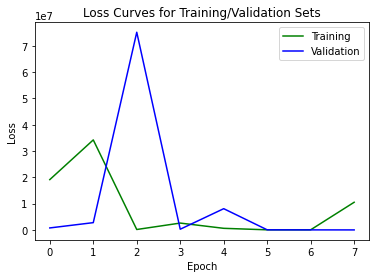

In [23]:
plot_loss_curves(history_cfis, figname="FiveTrainingTilesCFIS_CUSTLOSS_ronly.png")

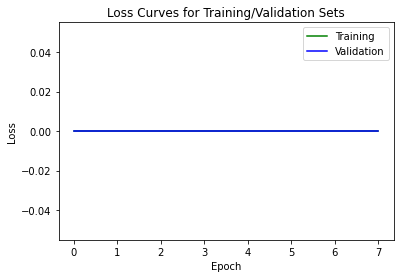

In [36]:
plot_loss_curves(history_cfis, figname="FiveTrainingTilesCFIS_CUSTLOSS.png")

In [29]:
test_index = 13
sources_test_cfis= get_test_cutouts(test_index, 50, CUTOUT_SIZE, "cfis")
#sources_test_ps1,  weights_test_ps1  = get_test_cutouts(test_index, 50, CUTOUT_SIZE, "ps1")

In [30]:
decoded_imgs_cfis = autoencoder_cfis.predict(sources_test_cfis)
residuals_cfis = sources_test_cfis - decoded_imgs_cfis

In [31]:
sources_test_cfis.shape

(50, 128, 128, 2)

In [33]:
def plot_images(images, figname, bands, start=0):
    #plots source, reconstructed and residuals for 1 image (start = index) for all bands
    fig, axes = plt.subplots(images.shape[0],len(bands), figsize=(2,20))
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.45)
    for row in range(images.shape[0]):
        for col in range(len(bands)):
            norm = ImageNormalize(images[row,:,:,col], interval=ZScaleInterval())
            im = axes[row][col].imshow(images[row,:,:,col], norm=norm)
            #fig.colorbar(im, fraction=0.045, ax=axes[row][col])
            if row == 0:
                axes[row][col].set_title(bands[col])
    plt.savefig("../Plots/" + figname)

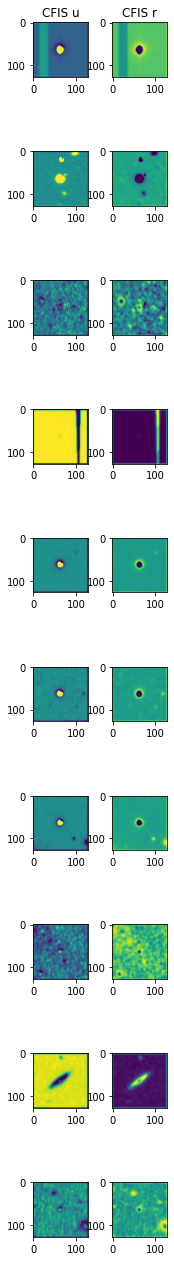

In [34]:
plot_images(decoded_imgs_cfis[:10,:,:,:], "Reconstructed Cutouts 185.270 with Cust Loss just r.png", bands=["CFIS u", "CFIS r"], start=2)

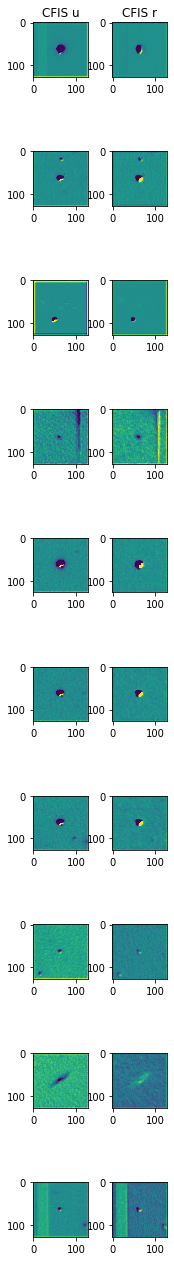

In [42]:
plot_images(decoded_imgs_cfis[:10,:,:,:], "Reconstructed Cutouts 185.270 with Cust Loss.png", bands=["CFIS u", "CFIS r"], start=2)

# Try with PS1

In [19]:
test_index = 13
cutout_size = 128

In [20]:
sources_test_ps1 = get_test_cutouts(test_index, 50, CUTOUT_SIZE, "ps1")

In [21]:
autoencoder_ps1 = create_autoencoder2((CUTOUT_SIZE, CUTOUT_SIZE, 3))
autoencoder_ps1.compile(optimizer="adam", loss=masked_MSE_with_uncertainty)